In [30]:
import torch
import math
import numpy as np
import imageio as iio
import os
import matplotlib.pyplot as plt

In [221]:
# offline setup
b = 4
N = 256
n = 256
omega = (math.pi/n)*np.linspace(0,n,n)

E = np.empty((N,N,n,n),dtype=np.complex64)
for i in range(N):
    for j in range(N):
        for k in range(n):
            for l in range(n):
                E[i,j,k,l] = np.exp(-1j*omega[k]*i) * np.exp(-1j*omega[l]*j)
                
E_ri = torch.from_numpy(np.stack([np.real(E), np.imag(E)]))

In [15]:
def fourier_dissimilarity(fake_images, real_images, metric):
    fake_ft = torch.norm(torch.rfft(rgb2gray(fake_images), signal_ndim=2), dim=3)
    real_ft = torch.norm(torch.rfft(rgb2gray(real_images), signal_ndim=2), dim=3)
    if metric == '1':
        return torch.norm(fake_ft-real_ft, p=1, dim=(1, 2))*1e-8
    elif metric == '2':
        return torch.norm(fake_ft-real_ft, p='fro', dim=(1, 2))*1e-7
    elif metric == 'cos':
        vec_fake_ft = torch.flatten(fake_ft, start_dim=1).unsqueeze(dim=1)
        vec_real_ft = torch.flatten(real_ft, start_dim=1).unsqueeze(dim=2)
        return 1 - torch.bmm(vec_fake_ft, vec_real_ft).squeeze() / (torch.norm(vec_fake_ft, dim=2) * torch.norm(vec_real_ft, dim=1)).squeeze()
    else:
        return 0

In [4]:
def rgb2gray(images):
    return 0.299*images[:,:,:,0] + 0.587*images[:,:,:,1] + 0.114*images[:,:,:,2]

In [206]:
def dft2D(images,E_ri,n,b):
    mag = torch.empty(b,n,n,dtype=torch.float32)
    for k in range(n):
        for l in range(n):
            real = torch.sum(E_ri[0,:,:,k,l]*images, dim=(1,2))
            imag = torch.sum(E_ri[1,:,:,k,l]*images, dim=(1,2))
            mag[:,k,l] = torch.sqrt(real**2 + imag**2)
    return mag

In [5]:
folder = 'real_examples'
images = []
for filename in os.listdir(folder):
    if not filename[0] == '.':
        img = iio.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
        
imagesA = np.array(images[0:4])
imagesB = np.array(images[4:8])

imagesA_tensor = torch.from_numpy(imagesA[:,:256,:256])
imagesB_tensor = torch.from_numpy(imagesB[:,:256,:256])

imagesA_tensor.shape

torch.Size([4, 256, 256, 3])

In [6]:
imagesA_gray = rgb2gray(imagesA_tensor)
imagesB_gray = rgb2gray(imagesB_tensor)

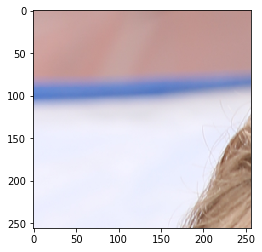

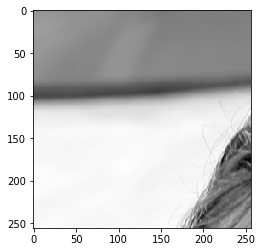

In [7]:
plt.imshow(imagesA_tensor[3])
plt.show()

plt.imshow(imagesA_gray[3],cmap='gray')
plt.show()

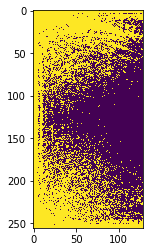

In [27]:
imagesA_dft = torch.norm(torch.rfft(rgb2gray(imagesA_tensor), signal_ndim=2), dim=3)
plt.imshow(imagesA_dft[0]>200)
plt.show()

In [24]:
fourier_dissimilarity(imagesA_tensor, imagesB_tensor, '1')

tensor([0.5217, 0.7798, 0.5219, 0.4096])

In [25]:
fourier_dissimilarity(imagesA_tensor, imagesB_tensor, '2')

tensor([0.5708, 0.8110, 0.5863, 0.9703])

In [26]:
fourier_dissimilarity(imagesA_tensor, imagesB_tensor, 'cos')

tensor([0.0584, 0.0699, 0.1041, 0.0112])